In [1]:
from glob import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, MaxPool2D, Dense

import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

In [5]:
os.listdir("../artifacts/data_ingestion/data")

['Cyst', 'Normal', 'Stone', 'Tumor']

In [6]:
imgPath = "../artifacts/training"
testPath = imgPath + "/test"
test_dir = os.listdir(testPath)
trainPath = imgPath + "/train"
train_dir = os.listdir(trainPath)
valPath = imgPath + "/val"
val_dir = os.listdir(valPath)
print(testPath, test_dir)
print(trainPath, train_dir)
print(valPath, val_dir)

../artifacts/training/test ['Cyst', 'Normal', 'Stone', 'Tumor']
../artifacts/training/train ['Cyst', 'Normal', 'Stone', 'Tumor']
../artifacts/training/val ['Cyst', 'Normal', 'Stone', 'Tumor']


In [7]:
def imageCount(fPath):
    imgList = [len(glob(fPath + "/" + ele + "/*.jpg")) for ele in os.listdir(fPath)]
    imgSum = sum(imgList)
    return imgSum, imgList

In [8]:
trainCount, trainList = imageCount(trainPath)
print("Total number of images in {} directory : {}".format("TRAIN",trainCount))
valCount, valList = imageCount(valPath)
print("Total number of images in {} directory : {}".format("VALIDATION",valCount))
testCount, testList = imageCount(testPath)
print("Total number of images in {} directory : {}".format("TEST",testCount))

Total number of images in TRAIN directory : 7466
Total number of images in VALIDATION directory : 2487
Total number of images in TEST directory : 2493


## Model building

In [9]:
train_datagen = ImageDataGenerator(rescale=1/255)
valid_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

train_dataset = train_datagen.flow_from_directory(trainPath,
                                                  target_size=(200, 200),
                                                  color_mode='grayscale', 
                                                  class_mode='categorical', 
                                                  batch_size=100,
                                                  )

test_dataset = test_datagen.flow_from_directory(testPath,
                                                target_size=(200, 200),
                                                class_mode='categorical',
                                                color_mode='grayscale',
                                                batch_size=100,
                                                shuffle=False
                                                )

valid_dataset = valid_datagen.flow_from_directory(valPath,
                                                  target_size=(200, 200),
                                                  class_mode='categorical',
                                                  batch_size=100,
                                                  color_mode='grayscale',
                                                  )

Found 7466 images belonging to 4 classes.
Found 2493 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


In [10]:
train_dataset.image_shape

(200, 200, 1)

In [6]:
model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', input_shape=train_dataset.image_shape))
model.add(MaxPool2D(2))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPool2D(2))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPool2D(2))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPool2D(2))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPool2D(2))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPool2D(2))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(4, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 64)       0

In [7]:
import keras
METRICS = ['accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall')
    ]
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=METRICS)

In [8]:
Info = model.fit(
                 train_dataset,
                 validation_data=valid_dataset,
                 epochs=5,
                 )

Epoch 1/5
75/75 [==============================] - 484s 6s/step - loss: 1.1727 - accuracy: 0.5296 - precision: 0.6286 - recall: 0.2931 - val_loss: 1.0032 - val_accuracy: 0.6530 - val_precision: 0.8464 - val_recall: 0.2481
Epoch 2/5
75/75 [==============================] - 147s 2s/step - loss: 0.8432 - accuracy: 0.6731 - precision: 0.7344 - recall: 0.5777 - val_loss: 0.6168 - val_accuracy: 0.7362 - val_precision: 0.7740 - val_recall: 0.6884
Epoch 3/5
75/75 [==============================] - 127s 2s/step - loss: 0.5085 - accuracy: 0.8040 - precision: 0.8350 - recall: 0.7635 - val_loss: 0.4085 - val_accuracy: 0.8758 - val_precision: 0.8821 - val_recall: 0.8697
Epoch 4/5
75/75 [==============================] - 141s 2s/step - loss: 0.2493 - accuracy: 0.9124 - precision: 0.9208 - recall: 0.9058 - val_loss: 0.1040 - val_accuracy: 0.9674 - val_precision: 0.9678 - val_recall: 0.9662
Epoch 5/5
75/75 [==============================] - 139s 2s/step - loss: 0.1118 - accuracy: 0.9634 - precision: 0

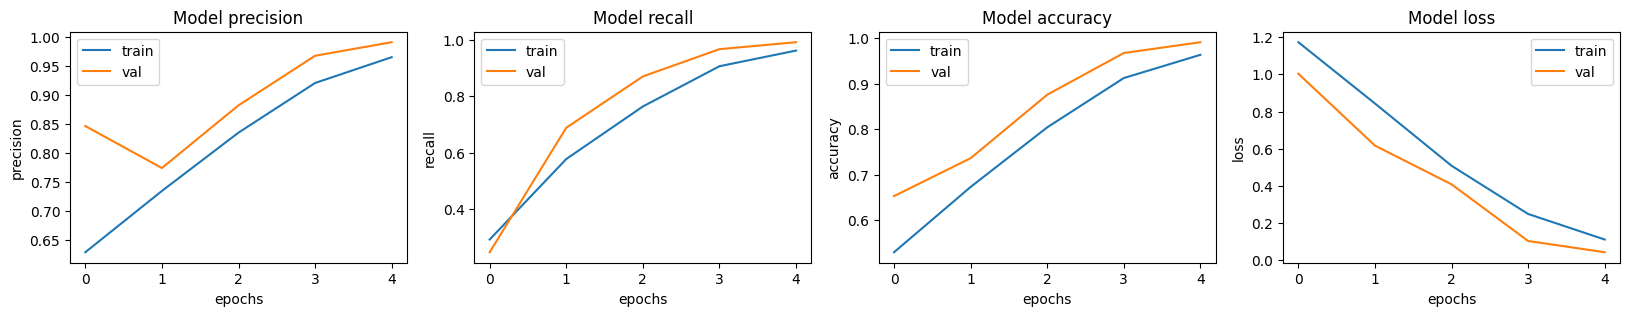

In [9]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(Info.history[met])
    ax[i].plot(Info.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [10]:
predictions = model.predict(test_dataset)

25/25 [==============================] - 111s 4s/step


In [34]:
predictions[0]

array([1.000000e+00, 5.904140e-15, 7.369151e-12, 6.731073e-11],
      dtype=float32)

In [39]:
def modelMetrics(actual_vlaues, predictions):
    
    predicted_values = [np.argmax(i) for i in predictions]
    rows_in_dataset = actual_vlaues.shape[0]
    accuracy = (predicted_values == actual_vlaues).sum() / rows_in_dataset
    print(f'Accuracy : {accuracy}')

    precision, recall, f1_score, _ = precision_recall_fscore_support(actual_vlaues, predicted_values, average='macro')
    print(f'Precision : {precision}')
    print(f'Recall : {recall}')
    print(f'F1_score : {f1_score}')
    return predicted_values

In [40]:
predicted_values = modelMetrics(test_dataset.classes,predictions)

Accuracy : 0.9919775371038909
Precision : 0.991019792215303
Recall : 0.9847021184555305
F1_score : 0.9877422392867744


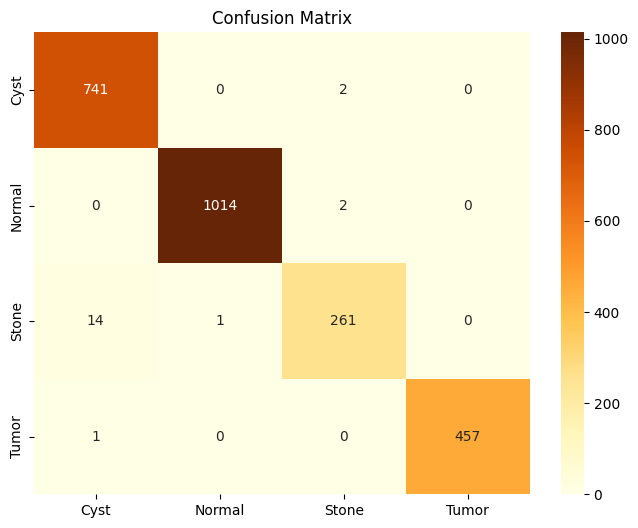

In [54]:
actual_vlaues = test_dataset.classes
diseases_labels = os.listdir(trainPath)
fig, ax = plt.subplots(figsize=(8,6))
conf_mat = confusion_matrix(actual_vlaues, predicted_values)
sns.heatmap(conf_mat, annot=True, fmt='.0f', cmap="YlOrBr", xticklabels=diseases_labels, yticklabels=diseases_labels)
plt.title('Confusion Matrix')
plt.show()

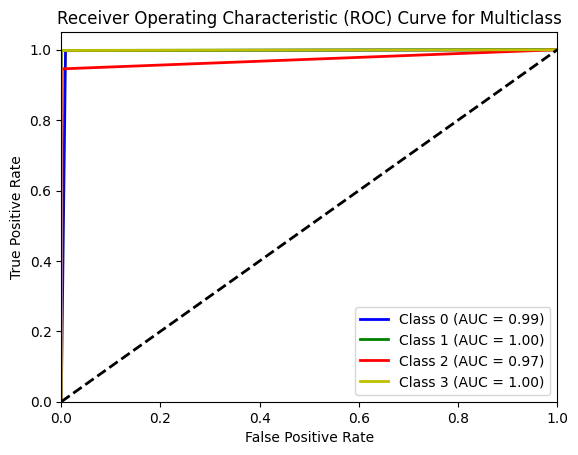

In [65]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Convert labels to one-hot encoded format
n_classes = 4  # The number of classes
y_true = label_binarize(actual_vlaues, classes=range(n_classes))
y_pred = label_binarize(predicted_values, classes=range(n_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves
plt.figure()
colors = ['b', 'g', 'r','y']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multiclass')
plt.legend(loc="lower right")
plt.show()
